# Machine Learning - Trabalho Prático 1

## Autores
- Gustavo Gurgel Medeiros (539226)
- Mário Martins Aragão (542056)
- Matheus Conrado Pires (536536)

## Sobre o dataset utilizado

- Nome: Rice (Cammeo and Osmancik)
- Link: [Rice UCI Rep (Cammeo and Osmancik)](https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik)
- Número de features: 7
- Número de instâncias: 3810
- Tipo de problema: Classification

# Configurando ambiente

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import zipfile
from scipy.io import arff
from pandas.plotting import scatter_matrix
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import pprint
from pathlib import Path
from os.path import join
from scipy.stats import randint


plt.style.use('seaborn-v0_8-pastel')

## Funções utilitárias

In [4]:
def load_rice_data():
    data_dir = Path("data")
    arff_file_name = "Rice_Cammeo_Osmancik.arff"
    final_arff_path = data_dir / arff_file_name

    zip_file_name = "rice_cammeo_osmancik.zip"
    zip_path = data_dir / zip_file_name

    if not final_arff_path.is_file():
        data_dir.mkdir(parents=True, exist_ok=True)
        url = (
            "https://archive.ics.uci.edu/static/public/545/rice+cammeo+and+osmancik.zip"
        )

        print(f"Downloading dataset from {url} to {zip_path}...")
        urllib.request.urlretrieve(url, zip_path)

        print(f"Extracting {zip_path} to {data_dir}...")
        with zipfile.ZipFile(zip_path, 'r') as rice_zip:
            rice_zip.extractall(path=data_dir)

        zip_path.unlink()
        print(f"Removed {zip_path}")
    else:
        print(f"ARFF file {final_arff_path} already exists. Loading directly.")

    print(f"Loading ARFF file from {final_arff_path}...")
    data_arff = arff.loadarff(final_arff_path)
    rice = pd.DataFrame(data_arff[0])

    # Converter coluna Class para uma string UTF-8
    # The 'Class' column in this ARFF is stored as bytes, needs decoding
    if 'Class' in rice.columns:
        rice['Class'] = rice['Class'].str.decode('utf-8')
    else:
        print(f"Warning: 'Class' column not found. Available columns: {rice.columns}")

    # Criar coluna binária que diz se uma instânica é ou não Cammeo
    rice['isCammeo'] = rice['Class'].apply(lambda x: 1 if x == 'Cammeo' else 0)
    rice['isCammeo'] = rice['isCammeo'].astype(np.uint8)

    return rice

## Importação dos dados

In [5]:
rice = load_rice_data()

Extracting data\rice_cammeo_osmancik.zip to data...
Removed data\rice_cammeo_osmancik.zip
Loading ARFF file from data\Rice_Cammeo_Osmancik.arff...


# Análise dos dados - Gustavo Gurgel

In [4]:
rice.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class,isCammeo
0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,Cammeo,1
1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,Cammeo,1
2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,Cammeo,1
3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,Cammeo,1
4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,Cammeo,1


-   **Area:** Medida da área da superfície do grão de arroz, obtida a partir da imagem processada.
-   **Perimeter:** Medida do contorno (perímetro) do grão de arroz na imagem.
-   **Major_Axis_Length:** Comprimento do eixo principal do grão, geralmente representando sua maior dimensão (comprimento).
-   **Minor_Axis_Length:** Comprimento do eixo menor do grão, geralmente representando sua menor dimensão (largura).
-   **Eccentricity:** Medida da elongação do grão, indicando o quão "esticado" ou circular ele é.
-   **Convex_Area:** Área do menor polígono convexo que pode envolver completamente o grão de arroz.
-   **Extent:** Razão entre a área do grão e a área do seu retângulo delimitador, indicando o quão bem o grão preenche esse retângulo.
-   **Class:** A espécie do grão de arroz, sendo 'Cammeo' ou 'Osmancik', que é o alvo da classificação.

<div style="display: flex">
<figure>
<img src="https://media.springernature.com/lw1200/springer-static/image/art%3A10.1007%2Fs00217-024-04614-9/MediaObjects/217_2024_4614_Fig3_HTML.png" width="400" height="400"/>
<figcaption>Fonte: springernature.com</figcaption>
</figure>

<figure>
<img src="https://www.researchgate.net/publication/384160271/figure/fig1/AS:11431281279048714@1726820572382/Osmancik-and-Cammeo-rice-structures.ppm" width="400" height="400"/>
<figcaption>Fonte: www.researchgate.net - Ahmet Çelik </figcaption>
</figure>
</div>

In [5]:
rice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   float64
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   float64
 6   Extent             3810 non-null   float64
 7   Class              3810 non-null   object 
 8   isCammeo           3810 non-null   uint8  
dtypes: float64(7), object(1), uint8(1)
memory usage: 242.0+ KB


O dataset **não possuí dados faltantes** e todas as suas features são do tipo ***float***.

O dataset tem 7 features de um total de 3810 instâncias


In [6]:
rice.describe()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,isCammeo
count,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000
mean,12667.727559,454.239180,188.776222,86.313750,0.886871,12952.496850,0.661934,0.427822
std,1732.367706,35.597081,17.448679,5.729817,0.020818,1776.972042,0.077239,0.494828
min,7551.000000,359.100006,145.264465,59.532406,0.777233,7723.000000,0.497413,0.000000
25%,11370.500000,426.144753,174.353855,82.731695,0.872402,11626.250000,0.598862,0.000000
50%,12421.500000,448.852493,185.810059,86.434647,0.889050,12706.500000,0.645361,0.000000
75%,13950.000000,483.683746,203.550438,90.143677,0.902588,14284.000000,0.726562,1.000000
max,18913.000000,548.445984,239.010498,107.542450,0.948007,19099.000000,0.861050,1.000000


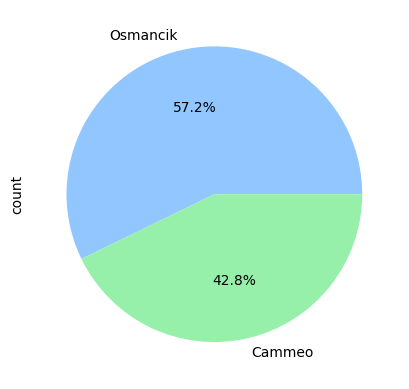

In [7]:
rice['Class'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

Vemos que o datasete não está balanceado.

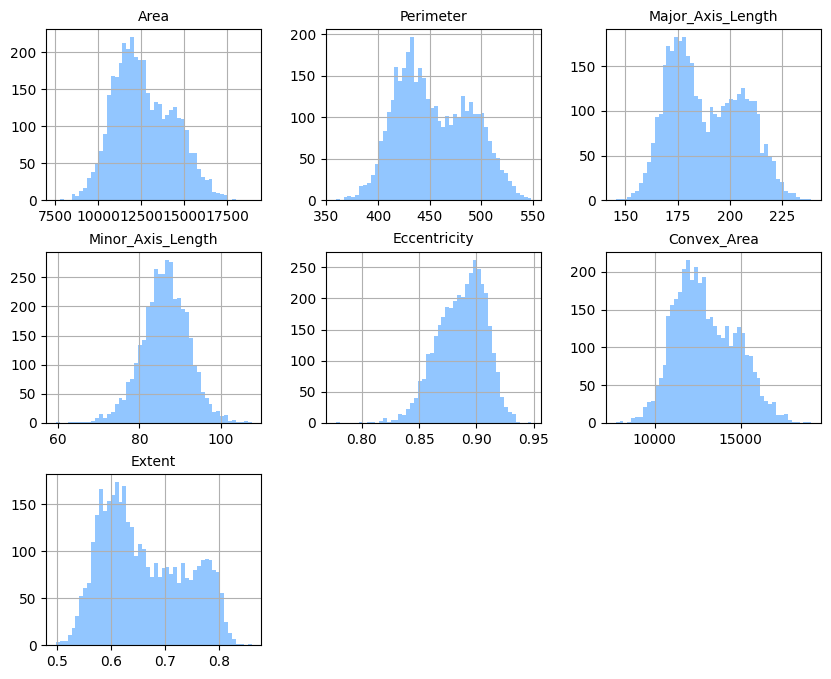

In [8]:
# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=10)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

rice.drop("isCammeo", axis=1).hist(bins=50, figsize=(10, 8))
plt.show()

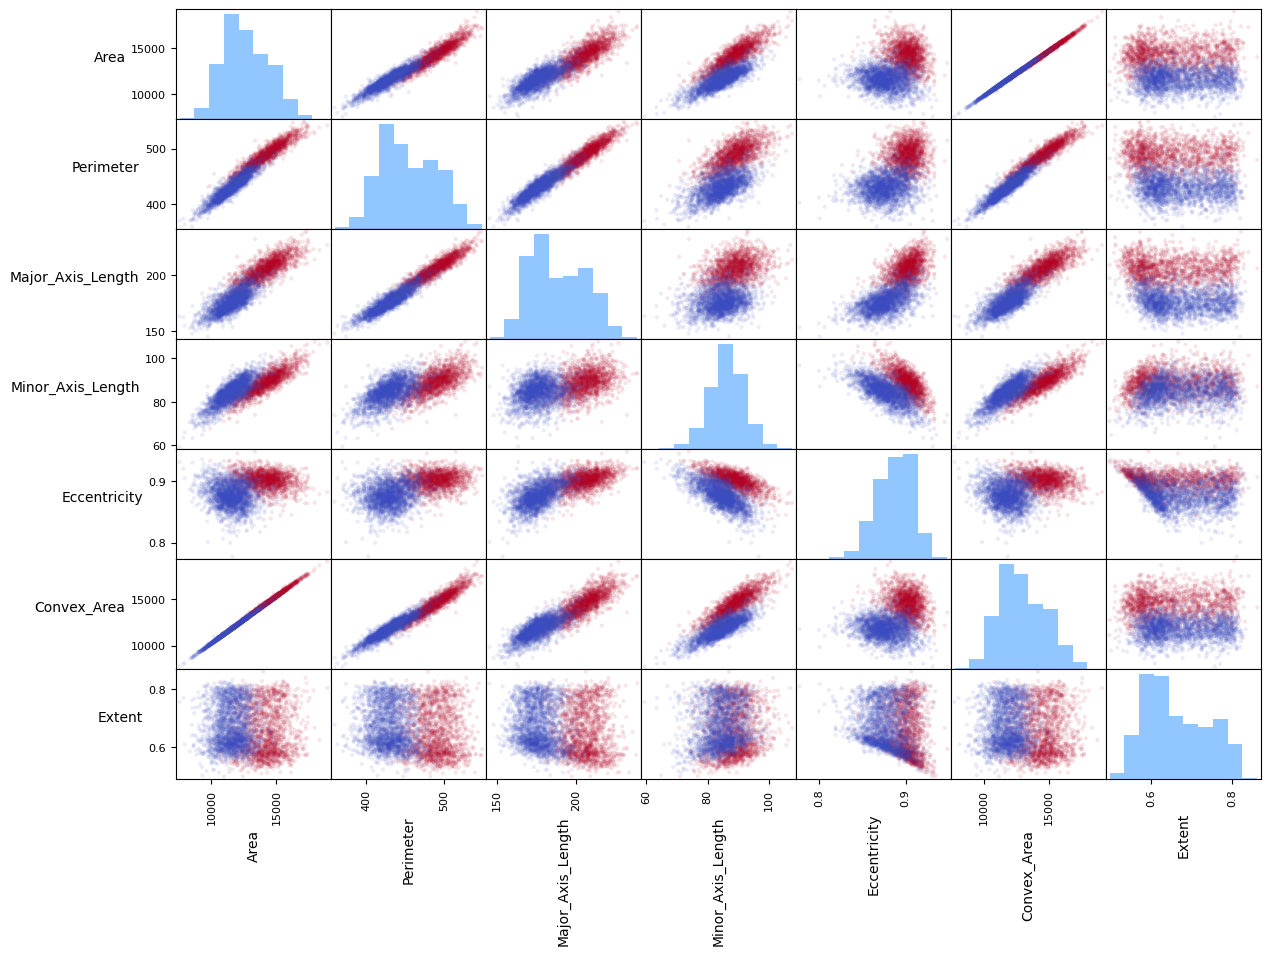

In [9]:
axes = scatter_matrix(rice.drop("isCammeo", axis=1), figsize=(14, 10), c=rice["isCammeo"], cmap="coolwarm", alpha=0.1)

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.show()

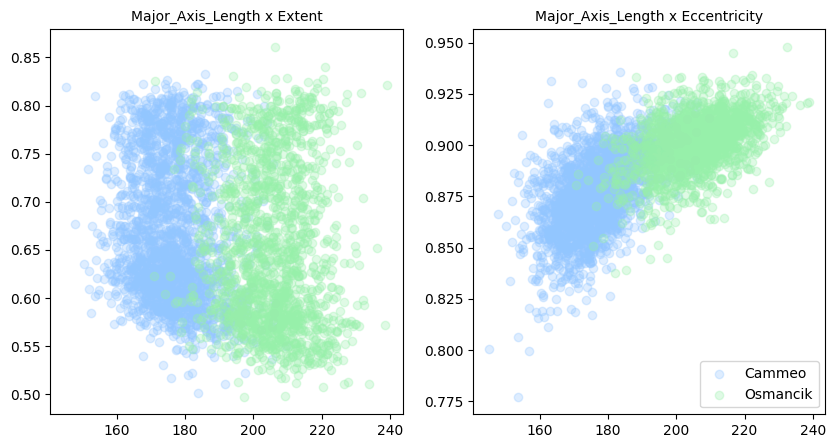

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("Major_Axis_Length x Extent")
ax[1].set_title("Major_Axis_Length x Eccentricity")
for value in [["Cammeo", 0], ["Osmancik", 1]]:
    ax[0].scatter(rice.loc[rice["isCammeo"] == value[1], "Major_Axis_Length"],
                  rice.loc[rice["isCammeo"] == value[1], "Extent"],
                  label=value[0],
                  alpha=0.3)
    ax[1].scatter(rice.loc[rice["isCammeo"] == value[1], "Major_Axis_Length"],
                  rice.loc[rice["isCammeo"] == value[1], "Eccentricity"],
                  label=value[0],
                  alpha=0.3)

plt.legend()
plt.show()

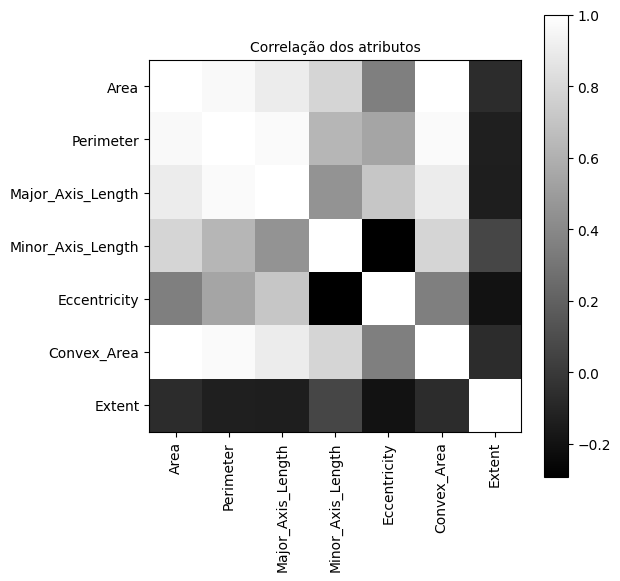

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.xticks(range(7), rice.columns[0:7], rotation=90)
plt.yticks(range(7), rice.columns[0:7])
plt.title("Correlação dos atributos")

im = ax.imshow(rice.iloc[:,0:7].corr(), cmap="gray")

fig.colorbar(im)

# Treinamento dos Modelos

## Separação do Dataset em Treino e Test

In [6]:
X = rice.drop(["Class", "isCammeo"], axis=1)
y = rice["isCammeo"]

scaler = StandardScaler()

# 70% para treino e 30% para teste
# Aplicando estratificação das classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# AJUSTAR APENAS NOS DADOS DE TREINAMENTO (evitar leak de dados)
X_train_scaled = scaler.fit_transform(X_train);
X_test_scaled = scaler.transform(X_test)

## Regressão Logística - Logistic Regression - Gustavo Gurgel

### Fazendo fine-tuning com GridSearch

In [13]:
# Features iniciais para fazer GridSearch

param_grid_log_reg_inital = [
    # Para solvers que aceitam penalty l2 ou None
    {
        'penalty': ['l2', None],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'max_iter': [100, 200, 500, 1000, 10000]
    },
    # Para solver liblinear (l1 ou l2)
    {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear'],
        # liblinear com valores baixos (100, 200..) não funciona pois não converge
        'max_iter': [1000, 10000]
    },
    # Para solver saga com l1, l2, ou None
    {
        'penalty': ['l1', 'l2', None],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'max_iter': [100, 200, 500, 1000, 10000]
    },
    # Para solver saga com elasticnet (onde l1_ratio é relevante)
    {
        'penalty': ['elasticnet'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'max_iter': [100, 200, 500, 1000, 10000],
        'l1_ratio': [0.3, 0.5, 0.7]
    }
]

#### Nos dados sem escalonamento

In [45]:
log_reg_base = LogisticRegression(random_state=42) # Estimador base

grid_search_log_reg_no_scale = GridSearchCV(
    estimator=log_reg_base,
    param_grid=param_grid_log_reg_inital,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# Ajustando o GridSerach
grid_search_log_reg_no_scale.fit(X_train, y_train)

# Melhor estimador encontrado
best_log_reg_no_scaled = grid_search_log_reg_no_scale.best_estimator_
best_params_log_reg_no_scaled = grid_search_log_reg_no_scale.best_params_
best_score_log_reg_no_scaled = grid_search_log_reg_no_scale.best_score_
print(f"Melhor estimador encontrado: {best_log_reg_no_scaled}")
print(f"Melhores parâmetros: {best_params_log_reg_no_scaled}")
print(f"Score do melhor estimador: {best_score_log_reg_no_scaled}")

Fitting 3 folds for each of 320 candidates, totalling 960 fits
Melhor estimador encontrado: LogisticRegression(C=10, random_state=42)
Melhores parâmetros: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Score do melhor estimador: 0.9794215853508281


c:\Users\gurge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Nos dados com escalonamento (StandardScaler)

In [ ]:
log_reg_base = LogisticRegression(random_state=42)

grid_search_log_reg_scaled = GridSearchCV(
    estimator=log_reg_base,
    param_grid=param_grid_log_reg_inital,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# Ajustando/Treinando o GridSerach
grid_search_log_reg_scaled.fit(X_train_scaled, y_train)

# Melhor estimador encontrado
best_log_reg_scaled = grid_search_log_reg_scaled.best_estimator_
best_params_log_reg_scaled = grid_search_log_reg_scaled.best_params_
best_score_log_reg_scaled = grid_search_log_reg_scaled.best_score_
print(f"Melhor estimador encontrado: {best_log_reg_scaled}")
print(f"Melhores parâmetros: {best_params_log_reg_scaled}")
print(f"Score do melhor estimador: {best_score_log_reg_scaled}")

Fitting 3 folds for each of 320 candidates, totalling 960 fits
Melhor estimador encontrado: LogisticRegression(C=100, random_state=42)
Melhores parâmetros: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Score do melhor estimador: 0.978937226219677


#### Análise desse fine-tuning

Na análise do fine-tuning, a melhor configuração para os dados sem escalonamento foi `LogisticRegression(C=10, max_iter=10000, penalty='l1', random_state=42, solver='liblinear')`. Para os dados com escalonamento (StandardScaler), os melhores parâmetros foram `{'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}`. O tempo de execução também diferiu significativamente.

#### Análise do modelo Logistic Regression final

In [104]:
y_predict = best_log_reg_scaled.predict(X_test_scaled)
pprint.pp(best_log_reg_scaled.get_params())

{'C': np.float64(111.0204081632653),
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': np.int64(100),
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


#### Treino vs Teste

In [105]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       654
           1       0.91      0.93      0.92       489

    accuracy                           0.93      1143
   macro avg       0.93      0.93      0.93      1143
weighted avg       0.93      0.93      0.93      1143



In [106]:
print(classification_report(y_train, best_log_reg_scaled.predict(X_train_scaled)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1526
           1       0.92      0.91      0.92      1141

    accuracy                           0.93      2667
   macro avg       0.93      0.93      0.93      2667
weighted avg       0.93      0.93      0.93      2667



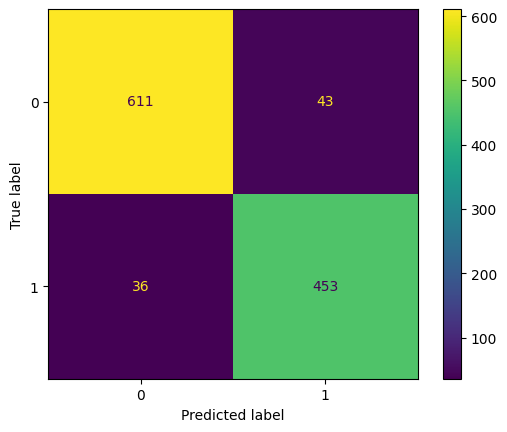

In [107]:
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_log_reg_scaled.classes_)
disp.plot()
plt.show()

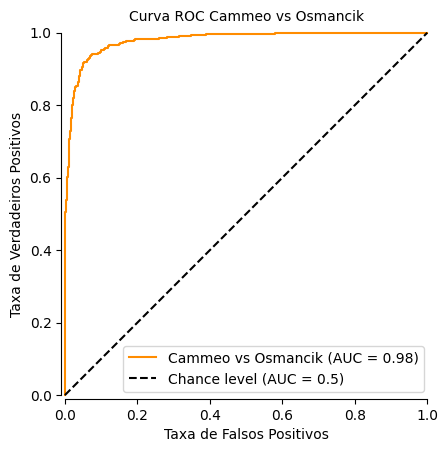

In [108]:
display = RocCurveDisplay.from_estimator(
    best_log_reg_scaled,
    X_test_scaled,
    y_test,
    name=f"Cammeo vs Osmancik",
    pos_label=1,
    color="darkorange",
    plot_chance_level=True,
    despine=True,
)
title_text = f"Curva ROC Cammeo vs Osmancik"

_ = display.ax_.set(
    xlabel="Taxa de Falsos Positivos",
    ylabel="Taxa de Verdadeiros Positivos",
    title=title_text,
)
plt.show()

## SVC - Support Vector Classifier - Matheus Conrado

O SVC (Support Vector Classifier) é um algoritmo de aprendizado de máquina baseado em vetores de suporte que busca encontrar o hiperplano ideal para separar diferentes classes em um espaço de características. Ele é especialmente eficaz em problemas de classificação binária e funciona bem com conjuntos de dados de alta dimensão. O SVC tenta maximizar a margem entre as classes, o que contribui para uma melhor generalização.



### Treinando inicialmente sem ajuste de hiperparâmetros e com dados não escalonados

In [23]:
svc_base = SVC(probability=True,random_state=42)
svc_base.fit(X_train,y_train)
y_pred_default = svc_base.predict(X_test)
y_scores = svc_base.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_scores)

print("Acurácia:", accuracy_score(y_test, y_pred_default))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_default))
print(f"ROC-AUC: {auc}")

Acurácia: 0.8757655293088364

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.86      0.93      0.90       654
           1       0.90      0.80      0.85       489

    accuracy                           0.88      1143
   macro avg       0.88      0.87      0.87      1143
weighted avg       0.88      0.88      0.87      1143

ROC-AUC: 0.9431061330931878


Já conseguimos um desempenho razoável com o modelo default, boa AUC (0.9431). Resultados razoáveis também nas demais métricas (accuracy, precision, recall, f1-score), mas com espaço para melhora (acurácia de 0.87). Agora tentaremos melhorar ainda mais com ajustes de hiperparâmetros e escalonamento de features.

### Definindo grid de hyperparams para fine-tuning com GridSearch

In [24]:
param_grid_svm = [
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear'],
        'max_iter': [100, 200, 500, 1000]
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'max_iter': [100, 200, 500, 1000]
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['poly'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto'],
        'coef0': [0, 0.1, 0.5],
        'max_iter': [100, 200, 500, 1000]
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['sigmoid'],
        'gamma': ['scale', 'auto'],
        'coef0': [0, 0.1, 0.5],
        'max_iter': [100, 200, 500, 1000]
    }
]

#### Nos dados sem escalonamento

In [25]:
svc_base = SVC(probability=True, random_state=42) # Estimador base

grid_search_svm_no_scale = GridSearchCV(
    estimator=svc_base,
    param_grid=param_grid_svm,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# Ajustando/Treinando o GridSerach
grid_search_svm_no_scale.fit(X_train, y_train)

# Melhor estimador encontrado
best_svm_no_scale = grid_search_svm_no_scale.best_estimator_
best_params_svm_no_scale = grid_search_svm_no_scale.best_params_
best_score_svm_no_scale = grid_search_svm_no_scale.best_score_
print(f"Melhor estimador encontrado: {best_svm_no_scale}")
print(f"Melhores parâmetros: {best_params_svm_no_scale}")
print(f"Score do melhor estimador: {best_score_svm_no_scale}")

Fitting 3 folds for each of 600 candidates, totalling 1800 fits
Melhor estimador encontrado: SVC(C=100, coef0=0.5, degree=4, kernel='poly', max_iter=1000, probability=True,
    random_state=42)
Melhores parâmetros: {'C': 100, 'coef0': 0.5, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 1000}
Score do melhor estimador: 0.963130364698671


c:\Users\gurge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Desempenho superior ao modelo default, se saindo bem melhor (ganho de 0.0219 em relação à AUC). Vamos tentar agora, com escalonamento de features.

#### Nos dados com escalonamento (StandarScaler)

In [26]:
svc_base = SVC(probability=True, random_state=42) # Estimador base

grid_search_svm_scaled = GridSearchCV(
    estimator=svc_base,
    param_grid=param_grid_svm,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1,
    return_train_score=True,
    refit=True
)

# Ajustando/Treinando o GridSerach
grid_search_svm_scaled.fit(X_train_scaled, y_train)

# Melhor estimador encontrado
best_svm_scaled = grid_search_svm_scaled.best_estimator_
best_params_svm_scaled = grid_search_svm_scaled.best_params_
best_score_svm_scaled = grid_search_svm_scaled.best_score_
print(f"Melhor estimador encontrado: {best_svm_scaled}")
print(f"Melhores parâmetros: {best_params_svm_scaled}")
print(f"Score do melhor estimador: {best_score_svm_scaled}")

Fitting 3 folds for each of 600 candidates, totalling 1800 fits
Melhor estimador encontrado: SVC(C=1, kernel='linear', max_iter=500, probability=True, random_state=42)
Melhores parâmetros: {'C': 1, 'kernel': 'linear', 'max_iter': 500}
Score do melhor estimador: 0.9790130782308922


c:\Users\gurge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Desempenho ligeiramente superior ao melhor modelo do gridSearch sem escalonamento (ganho de .0140 em relação à AUC) e muito superior ao modelo default (ganho de .0359). Nosso melhor modelo encontrado. Nota-se também uma mudança nos hiperparâmetros escolhidos, em relação ao modelo com dados não escalonados.

#### Análise do modelo final

In [27]:
y_predict = best_svm_scaled.predict(X_test_scaled)
pprint.pp(best_svm_scaled.get_params())

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': 500,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


##### Teste vs Treino

In [ ]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93       654
           1       0.88      0.94      0.91       489

    accuracy                           0.92      1143
   macro avg       0.92      0.92      0.92      1143
weighted avg       0.92      0.92      0.92      1143



In [29]:
print(classification_report(y_train, best_svm_scaled.predict(X_train_scaled)))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1526
           1       0.89      0.93      0.91      1141

    accuracy                           0.92      2667
   macro avg       0.92      0.92      0.92      2667
weighted avg       0.92      0.92      0.92      2667



Resultados muito similares, quase não há divergência. Excelente sinal de que não ocorreu overfitting.

##### Matriz de Confusão

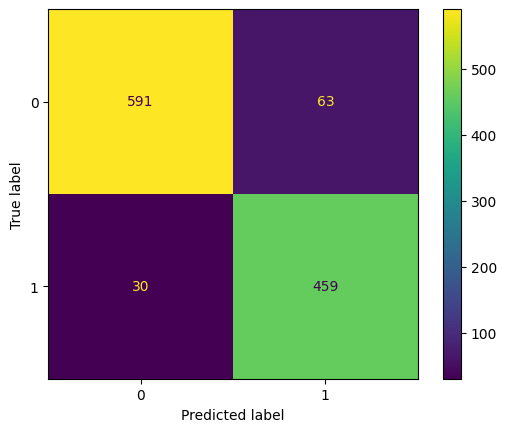

In [30]:
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_svm_scaled.classes_)
disp.plot()
plt.show()

##### Curva ROC

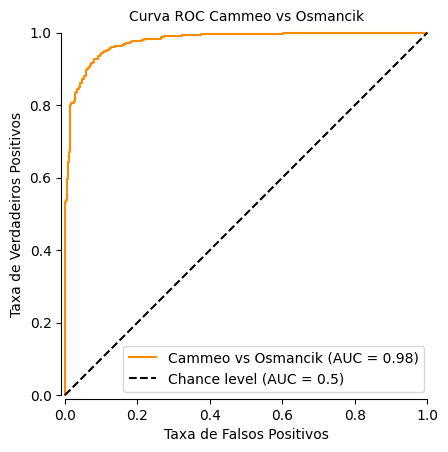

In [31]:
display = RocCurveDisplay.from_estimator(
    best_svm_scaled,
    X_test_scaled,
    y_test,
    name=f"Cammeo vs Osmancik",
    pos_label=1,
    color="darkorange",
    plot_chance_level=True,
    despine=True,
)
title_text = f"Curva ROC Cammeo vs Osmancik"

_ = display.ax_.set(
    xlabel="Taxa de Falsos Positivos",
    ylabel="Taxa de Verdadeiros Positivos",
    title=title_text,
)
plt.show()

## Random Forest - Random Forest Classifier - Mário Aragão

O random forest é um algoritmo de aprendizado de máquina que utiliza múltiplas árvores de decisão para melhorar a precisão e evitar o overfitting. Ele é particularmente eficaz em tarefas de classificação e regressão, combinando as previsões de várias árvores para obter um resultado mais robusto.

In [32]:
# Antes de usar metricas para encontrar o desempenho do nosso modelo vamos ver como ele está se saindo 'cru'.
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train,y_train)
y_pred_default = random_forest.predict(X_test)
y_scores = random_forest.predict_proba(X_test)[:, 1]
default_auc = roc_auc_score(y_test, y_scores)

print("Acurácia:", accuracy_score(y_test, y_pred_default))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_default))
print(f"ROC-AUC: {default_auc}")


Acurácia: 0.9212598425196851

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       654
           1       0.91      0.91      0.91       489

    accuracy                           0.92      1143
   macro avg       0.92      0.92      0.92      1143
weighted avg       0.92      0.92      0.92      1143

ROC-AUC: 0.9742687754451136


### Usaremos o GridSearchCV para encontrar os melhores parâmetros para o modelo Random Forest.
 O GridSearchCV é uma técnica de validação cruzada que nos permite testar diferentes combinações de hiperparâmetros e escolher a melhor configuração com base em uma métrica de desempenho, como a acurácia ou a pontuação ROC AUC. A depender do número de combinações de hiperparâmetros, o GridSearchCV pode levar um tempo considerável para ser executado. Portanto, é importante escolher uma grade de hiperparâmetros que seja razoável e não muito extensa.

In [33]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

# Criando o GridSearchCV
grid_search_sem_escalonamento = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    return_train_score= True
)

grid_search_sem_escalonamento.fit(X_train,y_train)

print("Melhor estimador", grid_search_sem_escalonamento.best_estimator_)
print("Melhores parametros: ", grid_search_sem_escalonamento.best_params_)
print("Melhor score", grid_search_sem_escalonamento.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Melhor estimador RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=400, random_state=42)
Melhores parametros:  {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 400}
Melhor score 0.9770947234144989


### GridSearchCV  modelo com escalonamento

In [7]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

# Criando o GridSearchCV
grid_search_com_escalonamento = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    return_train_score= True
)

grid_search_com_escalonamento.fit(X_train_scaled,y_train)

print("Melhor estimador", grid_search_com_escalonamento.best_estimator_)
print("Melhores parametros: ", grid_search_com_escalonamento.best_params_)
print("Melhor score", grid_search_com_escalonamento.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Melhor estimador RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=400, random_state=42)
Melhores parametros:  {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 400}
Melhor score 0.9770975900582324


O uso do GridSearchCV trouxe um ganho minimo de performace em relação ao modelo inicial, com um tempo de execução bem maior. Vamos testar outras abordagens para melhorar a performance do modelo Random Forest.
### RandomizedSearchCV
No RandomizedSearchCV, em vez de testar todas as combinações possíveis de hiperparâmetros, ele seleciona aleatoriamente um número fixo de combinações a partir da grade especificada.



In [8]:
rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': randint(100, 2000),
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': randint(2, 50),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(rf, param_dist, n_iter=100, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train);

In [36]:
print("Melhor estimador", random_search.best_estimator_)
print("Melhores parametros: ", random_search.best_params_)
print("Melhor score", random_search.best_score_)

Melhor estimador RandomForestClassifier(max_depth=5, min_samples_leaf=18, min_samples_split=27,
                       n_estimators=1679, random_state=42)
Melhores parametros:  {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 18, 'min_samples_split': 27, 'n_estimators': 1679}
Melhor score 0.977540114850771


In [37]:
y_pred = random_search.best_estimator_.predict(X_test)
print("Acuracia", accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

Acuracia 0.9256342957130359
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       654
           1       0.91      0.91      0.91       489

    accuracy                           0.93      1143
   macro avg       0.92      0.92      0.92      1143
weighted avg       0.93      0.93      0.93      1143



### Compração das matrizes de confusão

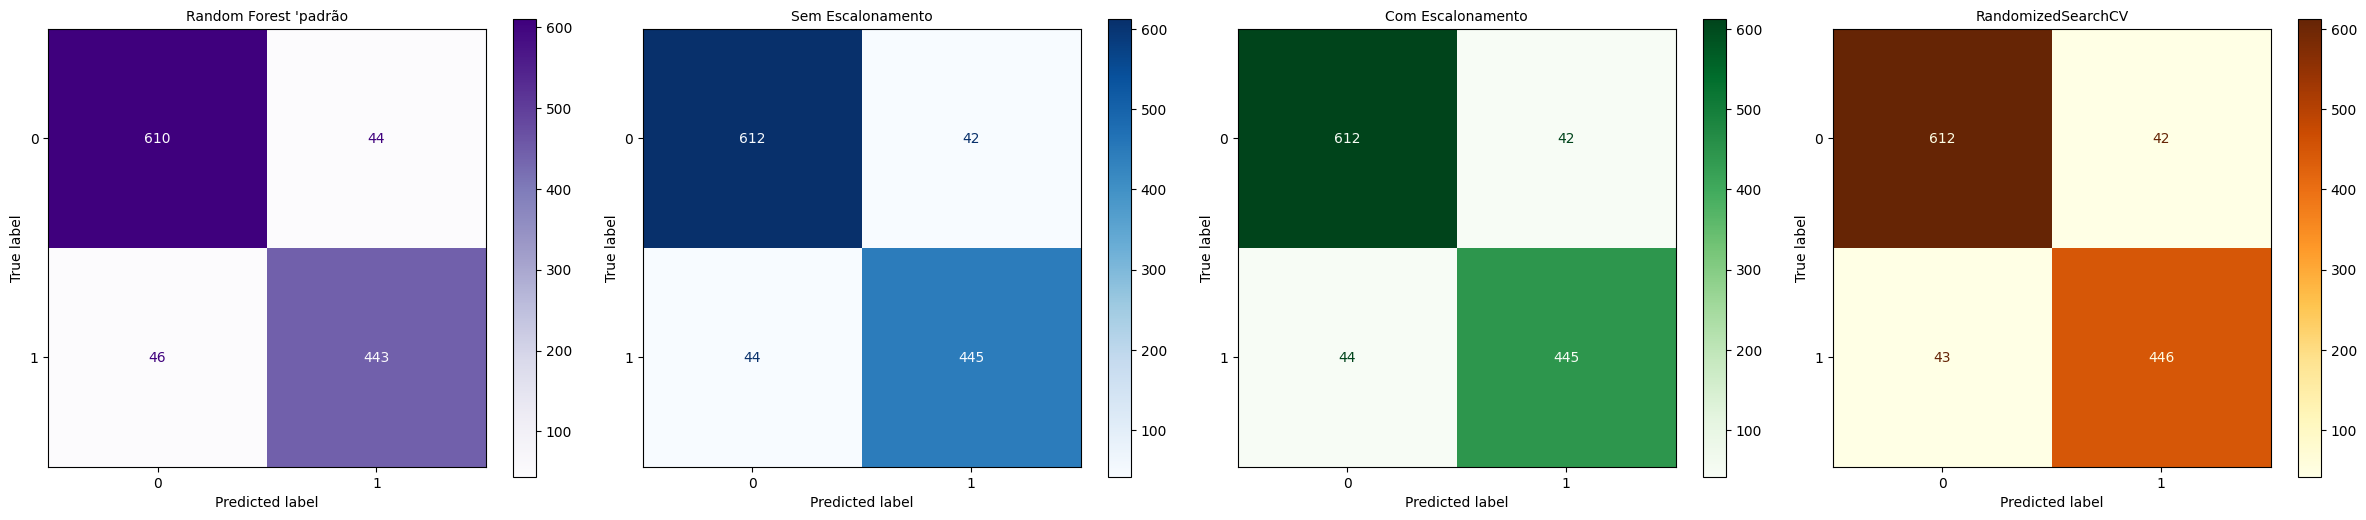

In [38]:

fig, axes = plt.subplots(1, 4, figsize=(24, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_default,
    ax=axes[0],
    cmap='Purples'
)
axes[0].set_title("Random Forest 'padrão")

ConfusionMatrixDisplay.from_estimator(
    grid_search_sem_escalonamento.best_estimator_,
    X_test,
    y_test,
    ax=axes[1],
    cmap='Blues'
)
axes[1].set_title("Sem Escalonamento")


ConfusionMatrixDisplay.from_estimator(
    grid_search_com_escalonamento.best_estimator_,
    X_test_scaled,
    y_test,
    ax=axes[2],
    cmap='Greens'
)
axes[2].set_title("Com Escalonamento")

ConfusionMatrixDisplay.from_estimator(
    random_search.best_estimator_,
    X_test,
    y_test,
    ax=axes[3],
    cmap="YlOrBr"
)
axes[3].set_title("RandomizedSearchCV")

plt.tight_layout()
plt.show()


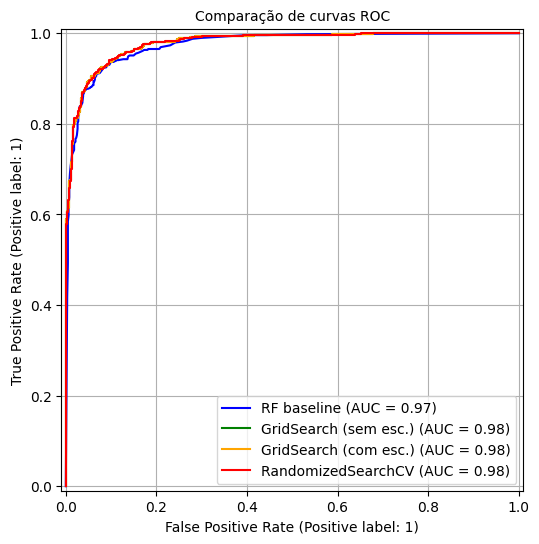

In [39]:
fig, ax = plt.subplots(figsize=(6, 6))

# 1) Random forest “cru”
RocCurveDisplay.from_estimator(
    random_forest, X_test, y_test,
    ax=ax,
    name="RF baseline",
    color="blue"
)

# 2) Melhor modelo do grid sem escalonamento
RocCurveDisplay.from_estimator(
    grid_search_sem_escalonamento.best_estimator_,
    X_test, y_test,
    ax=ax,
    name="GridSearch (sem esc.)",
    color="green"
)

# 3) Melhor modelo do grid com escalonamento
RocCurveDisplay.from_estimator(
    grid_search_com_escalonamento.best_estimator_,
    X_test_scaled, y_test,
    ax=ax,
    name="GridSearch (com esc.)",
    color="orange"
)

# 4) RandomizedSearchCV
RocCurveDisplay.from_estimator(
    random_search.best_estimator_,
    X_test, y_test,
    ax=ax,
    name="RandomizedSearchCV",
    color="red"
)

ax.set_title("Comparação de curvas ROC")
ax.grid(True)
plt.show()


In [54]:
resultados_rf = [
    (grid_search_com_escalonamento.best_score_, "RF com escalonamento", grid_search_com_escalonamento.best_params_, grid_search_com_escalonamento.best_estimator_),
    (grid_search_sem_escalonamento.best_score_, "RF sem escalonamento", grid_search_sem_escalonamento.best_params_, grid_search_sem_escalonamento.best_estimator_),
    (random_search.best_score_, "Random search", random_search.best_params_, random_search.best_estimator_),
    (default_auc, "RF cru", random_forest, random_forest)  # random_forest não tem best_params_
]

melhor_auc_rf, nome_modelo_rf, melhor_modelo_rf, melhor_estimador_rf = max(resultados_rf, key=lambda x: x[0])

best_rf_scaled = grid_search_com_escalonamento.best_estimator_
best_rf_no_scaled = random_search.best_estimator_

print(f"Melhor modelo: {nome_modelo_rf} com AUC = {melhor_auc_rf}\nMelhor parametro : {melhor_modelo_rf}\nMelhor estimador: {melhor_estimador_rf}")

Melhor modelo: Random search com AUC = 0.977540114850771
Melhor parametro : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 18, 'min_samples_split': 27, 'n_estimators': 1679}
Melhor estimador: RandomForestClassifier(max_depth=5, min_samples_leaf=18, min_samples_split=27,
                       n_estimators=1679, random_state=42)


Tiramos como conclusão que os modelos tem um desempenho semelhante, tendo o Random Forest 'cru' um desempenho um pouco abaixo dos outros.

# Conclusões

## Comparação das métricas em geral (Accuracy, Precision, Recall, F1-Score, ROC-AUC) - Matheus Conrado

In [119]:
results_data = []

models_to_evaluate = [
    ("LogReg Scaled", best_log_reg_scaled, X_train_scaled, y_train, X_test_scaled, y_test),
    ("LogReg No Scale", best_log_reg_no_scaled, X_train, y_train, X_test, y_test),
    ("SVM Scaled", best_svm_scaled, X_train_scaled, y_train, X_test_scaled, y_test),
    ("SVM No Scale", best_svm_no_scale, X_train, y_train, X_test, y_test),
    ("RF Scaled", best_rf_scaled, X_train_scaled, y_train, X_test_scaled, y_test),
    ("RF No Scale", best_rf_no_scaled, X_train, y_train, X_test, y_test),
]

for model_name, model, X_tr, y_tr, X_te, y_te in models_to_evaluate:
    y_pred_train = model.predict(X_tr)
    y_proba_train = model.predict_proba(X_tr)

    if len(np.unique(y_tr)) == 2: # Binário
        y_proba_train_positive = y_proba_train[:, 1]
        roc_auc_train = roc_auc_score(y_tr, y_proba_train_positive)
    else:
        roc_auc_train = roc_auc_score(y_tr, y_proba_train, multi_class='ovr', average='weighted')

    report_train = classification_report(y_tr, y_pred_train, output_dict=True, zero_division=0)
    results_data.append({
        "Modelo": model_name,
        "Conjunto": "Treino",
        "Accuracy": report_train['accuracy'],
        "Precision": report_train['weighted avg']['precision'],
        "Recall": report_train['weighted avg']['recall'],
        "F1-Score": report_train['weighted avg']['f1-score'],
        "ROC-AUC": roc_auc_train
    })

    y_pred_test = model.predict(X_te)
    y_proba_test = model.predict_proba(X_te)

    if len(np.unique(y_te)) == 2:
        y_proba_test_positive = y_proba_test[:, 1]
        roc_auc_test = roc_auc_score(y_te, y_proba_test_positive)
    else: 
        roc_auc_test = roc_auc_score(y_te, y_proba_test, multi_class='ovr', average='weighted')

    report_test = classification_report(y_te, y_pred_test, output_dict=True, zero_division=0)
    results_data.append({
        "Modelo": model_name,
        "Conjunto": "Teste",
        "Accuracy": report_test['accuracy'],
        "Precision": report_test['weighted avg']['precision'],
        "Recall": report_test['weighted avg']['recall'],
        "F1-Score": report_test['weighted avg']['f1-score'],
        "ROC-AUC": roc_auc_test
    })

df_results = pd.DataFrame(results_data)

metric_columns = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]

### Performace dos modelos ordenado pelas métricas

In [125]:
df_results[df_results["Conjunto"] == "Teste"].sort_values(by=metric_columns, ascending=False)

,Modelo,Conjunto,Accuracy,Precision,Recall,F1-Score,ROC-AUC
3,LogReg No Scale,Teste,0.934383,0.934501,0.934383,0.934424,0.979666
1,LogReg Scaled,Teste,0.930884,0.931074,0.930884,0.930943,0.979100
11,RF No Scale,Teste,0.925634,0.925616,0.925634,0.925625,0.978484
9,RF Scaled,Teste,0.924759,0.924726,0.924759,0.924740,0.978381
5,SVM Scaled,Teste,0.918635,0.920725,0.918635,0.918910,0.977111
7,SVM No Scale,Teste,0.734908,0.797645,0.734908,0.731175,0.911277


## Comparação gráfica da ROC-AUC - Mário Aragão

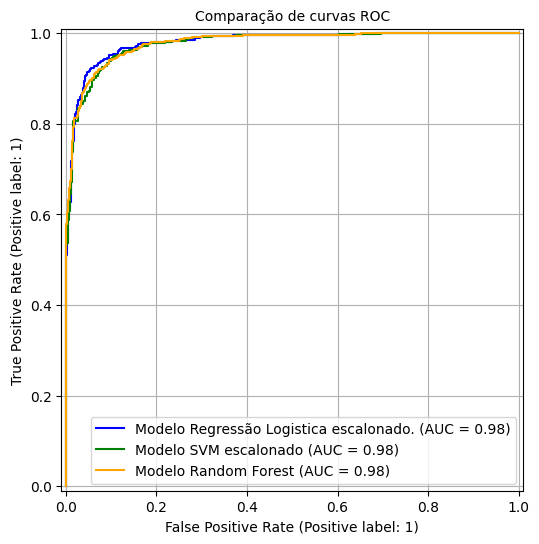

In [122]:
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_estimator(
    best_log_reg_no_scaled, X_test, y_test,
    ax=ax,
    name="Modelo Regressão Logistica escalonado.",
    color="blue"
)

RocCurveDisplay.from_estimator(
    best_svm_scaled,
    X_test_scaled, y_test,
    ax=ax,
    name="Modelo SVM escalonado",
    color="green"
)

RocCurveDisplay.from_estimator(
    melhor_estimador_rf,
    X_test, y_test,
    ax=ax,
    name="Modelo Random Forest",
    color="orange"
)


ax.set_title("Comparação de curvas ROC")
ax.grid(True)
plt.show()


## Considerações finais - Matheus Conrado

Com base nos resultados do conjunto de teste, o modelo 'LogReg No Scale' demonstrou o melhor desempenho geral, liderando em todas as métricas avaliadas, com um F1-Score de 0.9344 e ROC-AUC de 0.9797. A sua contraparte escalada, 'LogReg Scaled', apresentou resultados muito próximos (F1-Score de 0.9309, ROC-AUC de 0.9791), indicando que, para a Regressão Logística neste conjunto de dados específico, o escalonamento das features não trouxe um benefício substancial, e o modelo sem escalonamento foi ligeiramente superior.

Os modelos Random Forest ('RF No Scale' e 'RF Scaled') também se mostraram competitivos, com F1-Scores em torno de 0.9256 e 0.9247, respectivamente, e ROC-AUC próximo de 0.978. Similar à Regressão Logística, o escalonamento teve um impacto mínimo no desempenho do Random Forest. Por outro lado, o SVM exibiu uma forte dependência do escalonamento: 'SVM Scaled' obteve um F1-Score de 0.9189, enquanto 'SVM No Scale' apresentou um desempenho significativamente inferior (F1-Score de 0.7312), ressaltando a importância do pré-processamento adequado para algoritmos sensíveis à escala das features.